In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [4]:
# Function for Data Preprocessing
class BreastCancerDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(224, 224)):  # Fixed size
        self.image_paths = sorted(glob(os.path.join(image_dir, "*/*.png")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*/*.png")))
        self.labels = [0 if "benign" in path else 1 if "malignant" in path else 2 for path in self.image_paths]
        self.img_size = img_size  # Store fixed size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)  # Resize image

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size)  # Resize mask

        label = self.labels[idx]

        image = transforms.ToTensor()(image)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, mask, torch.tensor(label, dtype=torch.long)

# Function to load dataset
def load_dataset(image_dir, mask_dir, img_size=(224, 224)):
    return BreastCancerDataset(image_dir, mask_dir, img_size)


In [5]:
# Splitting Dataset into Train, Validation, and Test

def split_dataset(dataset, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15):
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    valid_size = int(valid_ratio * total_size)
    test_size = total_size - train_size - valid_size

    train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
    return train_dataset, valid_dataset, test_dataset

In [27]:
class HURNet(nn.Module):
    def __init__(self, num_classes=3):
        super(HURNet, self).__init__()
        self.encoder = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Remove FC layers

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        mask = self.decoder(features)
        mask = F.interpolate(mask, size=(224, 224), mode="bilinear", align_corners=False)  # Ensure 224x224 size

        pooled_features = self.global_avg_pool(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        classification = self.classifier(pooled_features)

        return mask, classification
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.models as models

# class HURNet(nn.Module):
#     def __init__(self, num_classes=3):
#         super(HURNet, self).__init__()

#         # Load ResNet-152 as encoder (without FC layers)
#         self.encoder = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
#         self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Remove FC layers

#         # Segmentation decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 1, kernel_size=1),
#             nn.Sigmoid()
#         )

#         # Classification head
#         self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.classifier = nn.Linear(2048, num_classes)

#     def forward(self, x):
#         features = self.encoder(x)  # Feature extraction

#         # Segmentation output
#         mask = self.decoder(features)
#         mask = F.interpolate(mask, size=(224, 224), mode="bilinear", align_corners=False)  # Resize to (224, 224)

#         # Classification output
#         pooled_features = self.global_avg_pool(features)
#         pooled_features = pooled_features.view(pooled_features.size(0), -1)
#         classification = self.classifier(pooled_features)

#         return mask, classification

# # Instantiate the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = HURNet(num_classes=3).to(device)

# print(model)



In [7]:
# Function for Dice Score and IoU
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = (y_true * y_pred).sum()
    return (2. * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + smooth) / (union + smooth)


In [8]:
# Function for Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    dice_scores = []
    iou_scores = []
    accuracies = []
    with torch.no_grad():
        for images, masks, labels in test_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            pred_masks, pred_labels = model(images)
            preds = torch.argmax(pred_labels, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

            dice_scores.append(dice_coefficient(masks.cpu(), pred_masks.cpu()))
            iou_scores.append(iou_score(masks.cpu(), pred_masks.cpu()))
            accuracies.append(accuracy_score(labels.cpu().numpy(), preds))

    accuracy = np.mean(accuracies)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(f"Dice Score: {avg_dice:.4f}, IoU Score: {avg_iou:.4f}")
    print("Confusion Matrix:\n", cm)
    return accuracy, f1, avg_dice, avg_iou, accuracies

In [9]:
# Function to Generate Accuracy and Loss Graphs
def plot_training_progress(epoch_losses, valid_losses, epoch_accuracies, valid_accuracies, steps_per_epoch=None, batch_size=None):
    plt.figure(figsize=(12,5))

    # Plot Training & Validation Loss
    plt.subplot(1,2,1)
    plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(valid_losses)+1), valid_losses, marker='o', linestyle='dashed', label='Validation Loss', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    title = "Training vs Validation Loss Over Epochs"
    if steps_per_epoch and batch_size:
        title += f" (Batch Size={batch_size}, Steps={steps_per_epoch})"
    plt.title(title)
    plt.legend()

    # Plot Training & Validation Accuracy
    plt.subplot(1,2,2)
    plt.plot(range(1, len(epoch_accuracies)+1), epoch_accuracies, marker='o', color='r', label='Training Accuracy')
    plt.plot(range(1, len(valid_accuracies)+1), valid_accuracies, marker='o', linestyle='dashed', color='blue', label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy Over Epochs")
    plt.legend()

    plt.show()


Epoch 1/50, Step 0/69, Loss: 1.8817
Epoch 1/50, Step 10/69, Loss: 0.9307
Epoch 1/50, Step 20/69, Loss: 1.3836
Epoch 1/50, Step 30/69, Loss: 0.9633
Epoch 1/50, Step 40/69, Loss: 0.8688
Epoch 1/50, Step 50/69, Loss: 0.9987
Epoch 1/50, Step 60/69, Loss: 0.4846
Epoch 1/50 - Loss: 1.1219 - Accuracy: 0.6264 - Val Loss: 1.1662 - Val Accuracy: 0.6410
Epoch 2/50, Step 0/69, Loss: 0.7041
Epoch 2/50, Step 10/69, Loss: 0.4918
Epoch 2/50, Step 20/69, Loss: 1.5289
Epoch 2/50, Step 30/69, Loss: 1.0640
Epoch 2/50, Step 40/69, Loss: 0.9289
Epoch 2/50, Step 50/69, Loss: 0.7780
Epoch 2/50, Step 60/69, Loss: 0.7786
Epoch 2/50 - Loss: 0.8813 - Accuracy: 0.7308 - Val Loss: 1.1121 - Val Accuracy: 0.5726
Epoch 3/50, Step 0/69, Loss: 0.7163
Epoch 3/50, Step 10/69, Loss: 0.4491
Epoch 3/50, Step 20/69, Loss: 0.6795
Epoch 3/50, Step 30/69, Loss: 0.5413
Epoch 3/50, Step 40/69, Loss: 0.3273
Epoch 3/50, Step 50/69, Loss: 0.5549
Epoch 3/50, Step 60/69, Loss: 0.7668
Epoch 3/50 - Loss: 0.6281 - Accuracy: 0.8297 - Val L

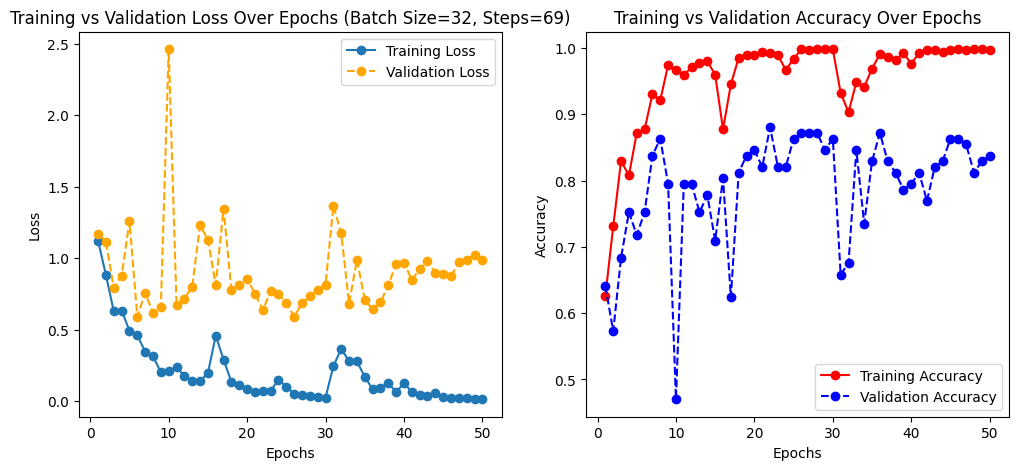

Model saved to /content/data/hurnet_model2.pth


In [29]:
# Set dataset paths
image_dir = "/content/data/images"  # Change this to your dataset path
mask_dir = "/content/data/masks"

# Load dataset with fixed image size
dataset = load_dataset(image_dir, mask_dir, img_size=(224, 224))

# Split dataset into train, validation, test sets
train_dataset, valid_dataset, test_dataset = split_dataset(dataset)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HURNet(num_classes=3).to(device)

# Define loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn_seg = nn.BCELoss()
loss_fn_cls = nn.CrossEntropyLoss()

# Train model
epochs = 50
batch_size = 32
steps_per_epoch = len(train_loader)
epoch_losses = []
epoch_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for step, (images, masks, labels) in enumerate(train_loader):
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        pred_masks, pred_labels = model(images)

        loss_mask = loss_fn_seg(pred_masks, masks)  # ✅ Removed `unsqueeze(1)`
        loss_cls = loss_fn_cls(pred_labels, labels)
        loss = loss_mask + loss_cls

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (torch.argmax(pred_labels, dim=1) == labels).sum().item()
        total += labels.size(0)

        if step % 10 == 0:  # Print updates every 10 steps
            print(f"Epoch {epoch+1}/{epochs}, Step {step}/{steps_per_epoch}, Loss: {loss.item():.4f}")

    epoch_losses.append(running_loss / steps_per_epoch)
    epoch_accuracies.append(correct / total)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_masks, val_labels in valid_loader:
            val_images, val_masks, val_labels = val_images.to(device), val_masks.to(device), val_labels.to(device)
            val_pred_masks, val_pred_labels = model(val_images)

            loss_mask = loss_fn_seg(val_pred_masks, val_masks)
            loss_cls = loss_fn_cls(val_pred_labels, val_labels)
            loss = loss_mask + loss_cls

            val_loss += loss.item()
            val_correct += (torch.argmax(val_pred_labels, dim=1) == val_labels).sum().item()
            val_total += val_labels.size(0)

    valid_losses.append(val_loss / len(valid_loader))
    valid_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_losses[-1]:.4f} - Accuracy: {epoch_accuracies[-1]:.4f} - Val Loss: {valid_losses[-1]:.4f} - Val Accuracy: {valid_accuracies[-1]:.4f}")

# Evaluate the model
evaluate_model(model, test_loader)

# Generate accuracy and loss plots
plot_training_progress(epoch_losses, valid_losses, epoch_accuracies, valid_accuracies, steps_per_epoch, batch_size)

# Save the model
model_save_path = "/content/data/hurnet_model2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")



<ipython-input-33-c93262561c94>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))


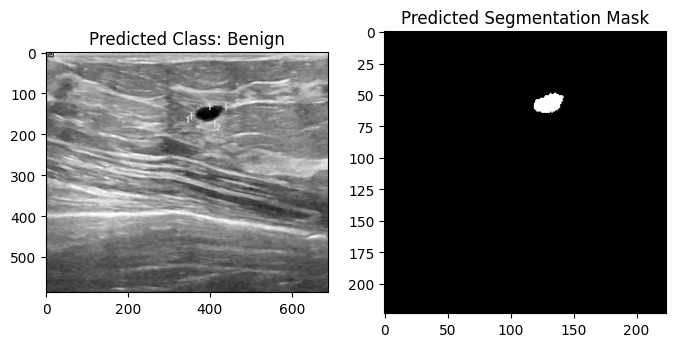

Predicted Class: Benign


In [33]:
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Define class labels
class_labels = ["Benign", "Malignant","Normal"]

# Define model architecture (Ensure it's the same as the trained model)
model = HURNet(num_classes=3)  # Replace with your model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model weights
model_save_path = "/content/data/hurnet_model2.pth"
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

# Define image preprocessing function
def preprocess_image(image_path, img_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")  # Load image
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Function to make predictions
def predict(image_path):
    image = preprocess_image(image_path)

    with torch.no_grad():
        pred_mask, pred_label = model(image)  # Get predictions

    # Convert segmentation mask to numpy array
    pred_mask = pred_mask.squeeze().cpu().numpy()  # Convert to NumPy
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold

    # Get classification label
    pred_class_idx = torch.argmax(pred_label, dim=1).item()  # Get class index
    pred_class = class_labels[pred_class_idx]  # Map index to label

    return pred_mask, pred_class

# Example Usage
image_path = "/content/data/images/benign/benign (11).png"  # Change to your test image path
pred_mask, pred_class = predict(image_path)

# Display the results
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path))
plt.title(f"Predicted Class: {pred_class}")

# Predicted Mask
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Segmentation Mask")

plt.show()

print(f"Predicted Class: {pred_class}")  # Print the predicted class
